#**Read data file and prepare time series data**
1. Read in the relevant data file content into a Dataframe
2. Analyse and understand the data.
3. Set the index as datetime field and add more datetime related fields for machine learning.

In [444]:
%matplotlib inline
import matplotlib.pylab as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns # theme & dataset
import sys
import tensorflow as tf

# Amend the filename depending on the dataset assigned to you
anime_clean = pd.read_csv("/content/anime_clean.csv")
# Convert 'start_date' to datetime and extract year-month as a string 'YYYY-MM'
anime_clean['start_date'] = pd.to_datetime(anime_clean['start_date'])
anime_clean['year_month'] = anime_clean['start_date'].dt.strftime('%Y-%m')
print(anime_clean.head())

                          title_x   type    source  episodes           status  \
0                    Cowboy Bebop     TV  Original      26.0  Finished Airing   
1  Cowboy Bebop Tengoku no Tobira  Movie  Original       1.0  Finished Airing   
2                          Trigun     TV     Manga      26.0  Finished Airing   
3              Witch Hunter Robin     TV  Original      26.0  Finished Airing   
4                  Bouken Ou Beet     TV     Manga      52.0  Finished Airing   

        duration  score  scored_by    rank  popularity  ...  \
0  24 min per ep   8.75   961043.0    46.0          43  ...   
1    1 hr 55 min   8.38   214605.0   191.0         618  ...   
2  24 min per ep   8.22   372073.0   347.0         252  ...   
3  25 min per ep   7.24    43768.0  3036.0        1849  ...   
4  23 min per ep   6.93     6516.0  4538.0        5349  ...   

   statistics_watching  statistics_completed statistics_on_hold  \
0               172641               1074282             106532   


In [445]:
# Convert 'year_month' column to datetime type
anime_clean['year_month'] = pd.to_datetime(anime_clean['year_month']).dt.to_period('M')
# Set 'year_month' column as the index
anime_clean.set_index('year_month', inplace=True)

anime_clean.sort_index(inplace=True)

In [446]:
#action_anime = anime_clean[anime_clean['final_genres'].str.contains('Slice of Life')] the r^2 for genre is below 0.75, so we switched to studio instead

#genre_firsts = []

for i in anime_clean.index:
  anime_clean['first_genre'] = anime_clean['final_genres'].apply(lambda x: x.split(',')[0])

studio_anime = anime_clean[anime_clean['first_genre'].str.contains('Action')]

studio_anime = studio_anime[(studio_anime.index >='1980-01')]

print(studio_anime.head())

                                                title_x     type   source  \
year_month                                                                  
1980-01                                Ulysses 31 Pilot  Special  Unknown   
1980-01                         15 Sonyeon Uju Pyoryugi    Movie  Unknown   
1980-02     Time Bokan Series Time Patroltai Otasukeman       TV  Unknown   
1980-03                          Uchuu Taitei God Sigma       TV  Unknown   
1980-04                                      Terra e...    Movie    Manga   

            episodes           status       duration  score  scored_by  \
year_month                                                               
1980-01          1.0  Finished Airing         24 min   5.73      272.0   
1980-01          1.0  Finished Airing    1 hr 18 min   5.40      164.0   
1980-02         53.0  Finished Airing  25 min per ep   6.51      403.0   
1980-03         50.0  Finished Airing  25 min per ep   7.09      444.0   
1980-04         

In [447]:
len(studio_anime)

3952

In [448]:
studio_anime.columns

Index(['title_x', 'type', 'source', 'episodes', 'status', 'duration', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'synopsis',
       'season', 'studios', 'start_date', 'end_date', 'final_genres',
       'statistics_watching', 'statistics_completed', 'statistics_on_hold',
       'statistics_dropped', 'statistics_plan_to_watch',
       'statistics_num_list_users', 'completion_rate', 'drop_rate',
       'retention_rate', 'first_genre'],
      dtype='object')

In [449]:
studio_anime.drop(['title_x', 'type', 'source', 'episodes', 'status', 'synopsis',
       'season', 'studios', 'start_date', 'end_date', 'final_genres',
       'first_genre', 'duration'], axis=1, inplace=True)
studio_anime.columns

Index(['score', 'scored_by', 'rank', 'popularity', 'members', 'favorites',
       'statistics_watching', 'statistics_completed', 'statistics_on_hold',
       'statistics_dropped', 'statistics_plan_to_watch',
       'statistics_num_list_users', 'completion_rate', 'drop_rate',
       'retention_rate'],
      dtype='object')

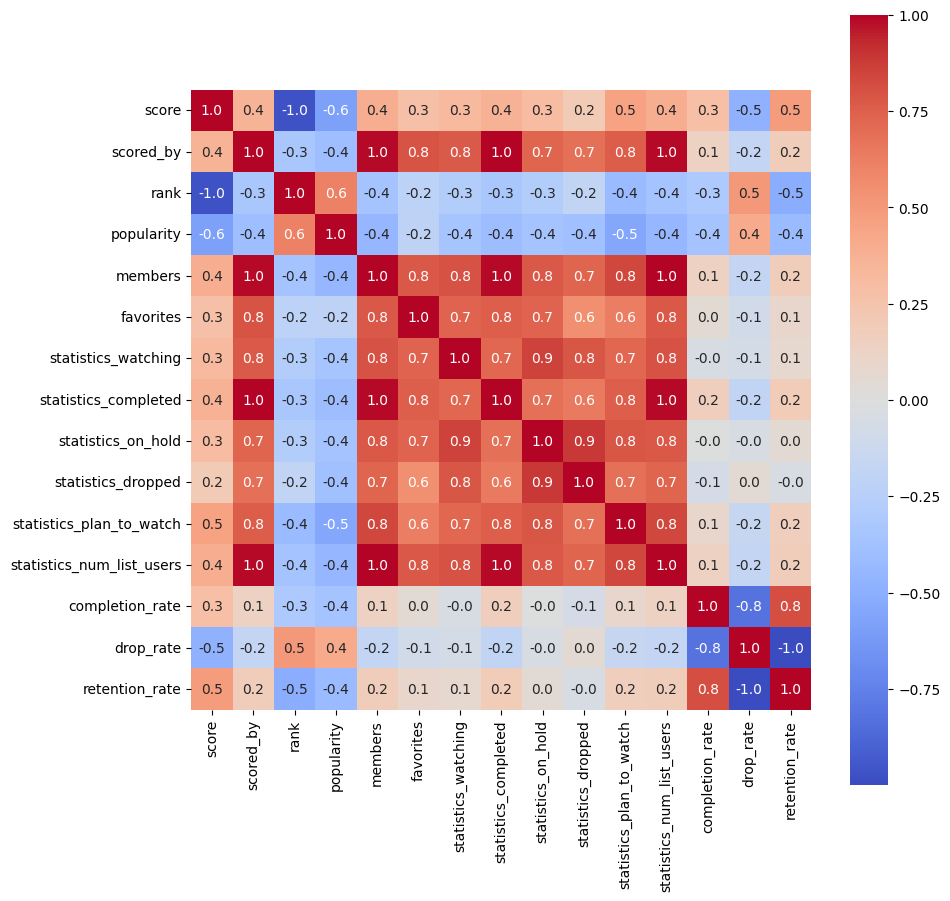

In [450]:
corr = studio_anime.corr(method = "pearson")
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap="coolwarm", square=True, ax=ax, annot=True, fmt=".1f");

Most corr with score is popularity and statistic plan to watch, so we will use these variables.

In [451]:
studio_anime.drop(['scored_by', 'rank', 'members', 'favorites',
       'statistics_watching', 'statistics_completed', 'statistics_on_hold',
       'statistics_dropped',
       'statistics_num_list_users', 'completion_rate', 'drop_rate',
       'retention_rate'], axis=1, inplace=True)
studio_anime.columns

Index(['score', 'popularity', 'statistics_plan_to_watch'], dtype='object')

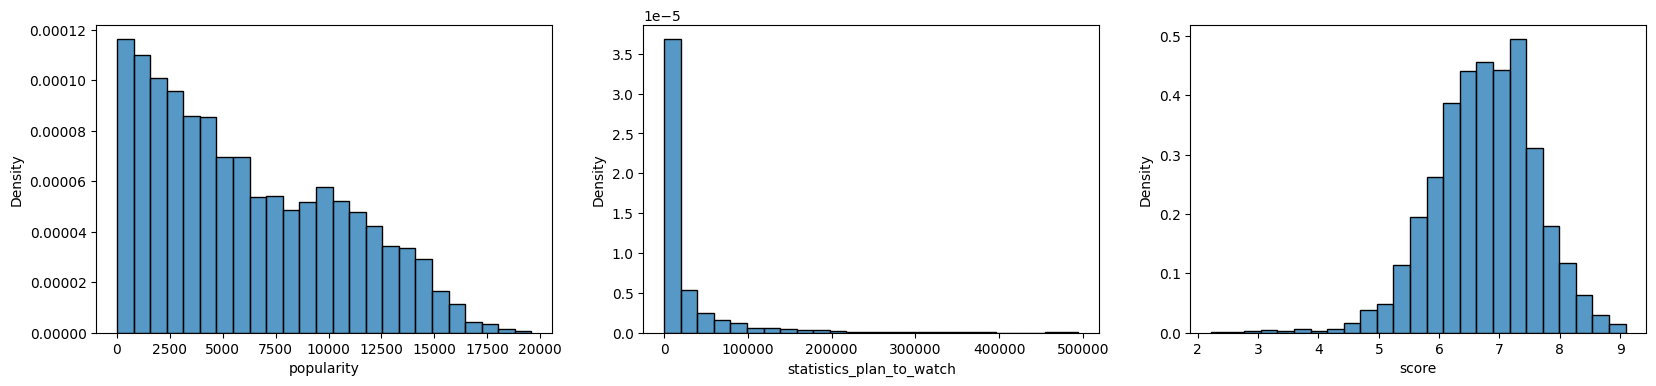

In [452]:
f, ax = plt.subplots(1,3,figsize=(20,4))
sns.histplot(studio_anime['popularity'], stat="density", bins=25, ax=ax[0])
sns.histplot(studio_anime['statistics_plan_to_watch'], stat="density", bins=25, ax=ax[1])
sns.histplot(studio_anime['score'], stat="density", bins=25, ax=ax[2]);

#**Machine Learning**
Although heatmap shows moderate corr and data for Action genre anime between plan to watch and score, it is limited, we will attempt to apply ML.

In [453]:
# Split the dataset into features and labels, X [features] and Y[label]
X = studio_anime[['score', 'statistics_plan_to_watch']]

y = studio_anime['popularity']

In [454]:
print(X.dtypes)
print(y.dtypes)

score                       float64
statistics_plan_to_watch      int64
dtype: object
int64


In [455]:
# Train-test split using sklearn package
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #test_size = 0.2 is to split data into 80 and 20

In [456]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_err = mean_squared_error(y_test,y_pred)
mean_absolute_err = mean_absolute_error(y_test,y_pred)
r_squared = r2_score(y_test, y_pred)
print('mse = {}'.format(mean_squared_err))
print('mae = {}'.format(mean_absolute_err))
print('r2 = {}'.format(r_squared))

mse = 10155724.758772982
mae = 2593.022014238794
r2 = 0.4651534522022065


In [457]:
# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

model = Ridge(alpha = 0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_err = mean_squared_error(y_test,y_pred)
mean_absolute_err = mean_absolute_error(y_test,y_pred)
r_squared = r2_score(y_test, y_pred)
print('mse = {}'.format(mean_squared_err))
print('mae = {}'.format(mean_absolute_err))
print('r2 = {}'.format(r_squared))

mse = 10155799.055696383
mae = 2593.060195670172
r2 = 0.465149539389095


In [458]:
#KNeighbours Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_err = mean_squared_error(y_test,y_pred)
mean_absolute_err = mean_absolute_error(y_test,y_pred)
r_squared = r2_score(y_test, y_pred)
print('mse = {}'.format(mean_squared_err))
print('mae = {}'.format(mean_absolute_err))
print('r2 = {}'.format(r_squared))

mse = 1039229.2657901391
mae = 757.3544879898864
r2 = 0.9452694713197951


In [459]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_err = mean_squared_error(y_test,y_pred)
mean_absolute_err = mean_absolute_error(y_test,y_pred)
r_squared = r2_score(y_test, y_pred)
print('mse = {}'.format(mean_squared_err))
print('mae = {}'.format(mean_absolute_err))
print('r2 = {}'.format(r_squared))

mse = 1572541.8369152972
mae = 928.6510745891277
r2 = 0.9171828113975624


In [460]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_err = mean_squared_error(y_test,y_pred)
mean_absolute_err = mean_absolute_error(y_test,y_pred)
r_squared = r2_score(y_test, y_pred)
print('mse = {}'.format(mean_squared_err))
print('mae = {}'.format(mean_absolute_err))
print('r2 = {}'.format(r_squared))

mse = 980215.1503833287
mae = 734.0026489675516
r2 = 0.9483774224159891


In [461]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_err = mean_squared_error(y_test,y_pred)
mean_absolute_err = mean_absolute_error(y_test,y_pred)
r_squared = r2_score(y_test, y_pred)
print('mse = {}'.format(mean_squared_err))
print('mae = {}'.format(mean_absolute_err))
print('r2 = {}'.format(r_squared))

mse = 790331.944980679
mae = 660.406237538625
r2 = 0.9583775336150108


In [462]:
print(y_test[:100].shape)
print(y_pred[:100].shape)

(100,)
(100,)


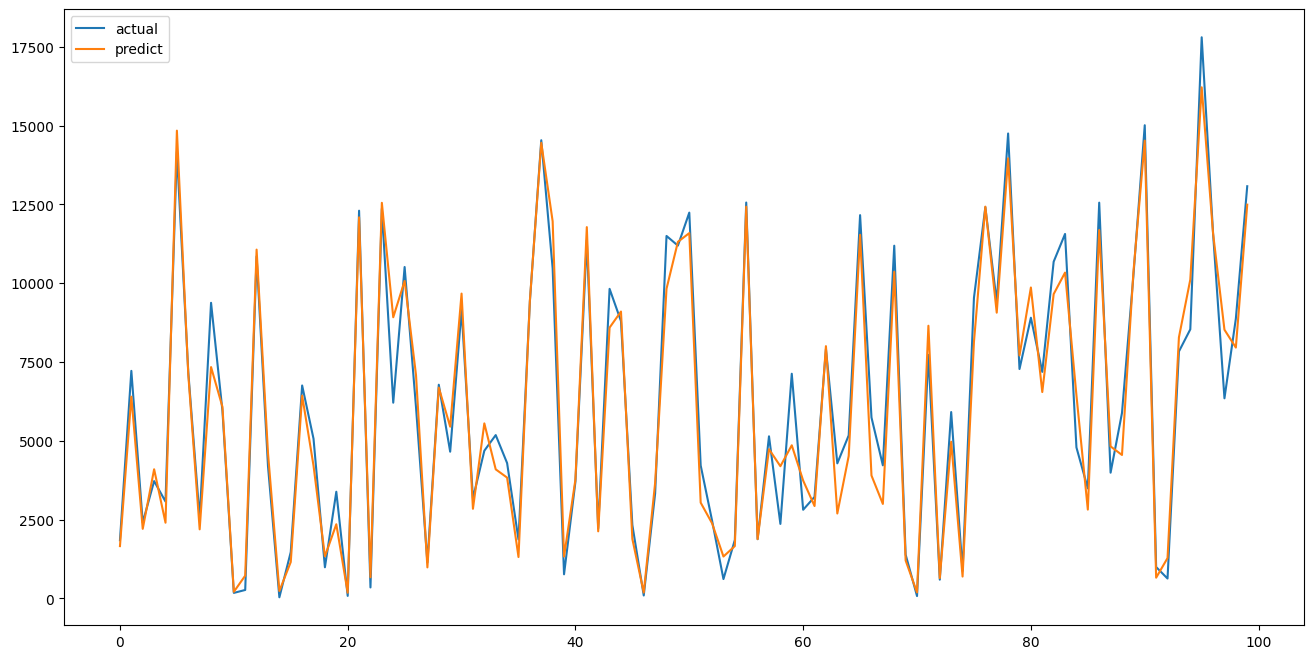

In [463]:
import numpy as np
import matplotlib.pyplot as plt

axis_x = [i for i in range(100)]
plt.figure(figsize=(16, 8))
plt.plot(axis_x, y_test[:100], label='actual')
plt.plot(axis_x, y_pred[:100], label='predict')
plt.legend()
plt.show()

Gradient Boosting provided the best r^2 result (r^2>95%), this may be due to the non-linear nature of our data. Because gradient boosting finds any nonlinear relationship between a model target and features and has great usability that can deal with missing values, outliers, and high cardinality categorical values on your features without any special treatment.

#**Further Analysis of Models**

In [464]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

models=[("Linear Regression", LinearRegression()),
        ("Ridge Regression", Ridge()),
        ("KNeighbors", KNeighborsRegressor()),
        ("Gradient Boosting", GradientBoostingRegressor()),
        ("Decision Tree", DecisionTreeRegressor()),
        ("Random Forest", RandomForestRegressor())]

all_data=[]
scoring = {'r2': 'r2',
           'mean_absolute_error': 'neg_mean_absolute_error',
           'mean_squared_error': 'neg_mean_squared_error'}

for name, model in models:
    results = cross_validate(model, X_train, y_train, cv=10, scoring=scoring)
    all_data.append({'model':name, 'score':results})
    print(f"{name}: {results['test_r2'].mean():.3f} , {results['test_mean_squared_error'].mean():.3f} , {results['test_mean_absolute_error'].mean():.3f}" )

Linear Regression: 0.436 , -11076356.313 , -2683.689
Ridge Regression: 0.436 , -11076366.824 , -2683.788
KNeighbors: 0.949 , -987478.606 , -734.398
Gradient Boosting: 0.961 , -759241.569 , -641.515
Decision Tree: 0.924 , -1474018.808 , -885.157
Random Forest: 0.955 , -880751.505 , -687.057


In [465]:
studio_anime.describe()

,score,popularity,statistics_plan_to_watch
count,3952.000000,3952.000000,3952.000000
mean,6.759517,6096.817055,23800.184464
std,0.840457,4431.231969,47042.782629
min,2.220000,1.000000,41.000000
25%,6.240000,2292.750000,1308.750000
50%,6.790000,5208.500000,5557.500000
75%,7.330000,9607.250000,23449.500000
max,9.090000,19586.000000,494639.000000


In [466]:
performance = {'model':[], 'r2':[], 'mse':[], 'mae':[]}

for d in all_data:
    performance['model'].append(d['model'])
    performance['r2'].append(np.abs(d['score']['test_r2'].mean())*100)
    performance['mse'].append(np.abs(d['score']['test_mean_squared_error'].mean()))
    performance['mae'].append(np.abs(d['score']['test_mean_absolute_error'].mean()))

print(performance)

{'model': ['Linear Regression', 'Ridge Regression', 'KNeighbors', 'Gradient Boosting', 'Decision Tree', 'Random Forest'], 'r2': [43.58260347690218, 43.582642722776335, 94.93241281061303, 96.1041058353045, 92.38007806253243, 95.46917120617367], 'mse': [11076356.313274981, 11076366.824081287, 987478.6060684023, 759241.5685163635, 1474018.8077399372, 880751.5047035217], 'mae': [2683.689040726716, 2683.7878690229136, 734.3979792756458, 641.5149427619936, 885.1574007706744, 687.0566700043307]}


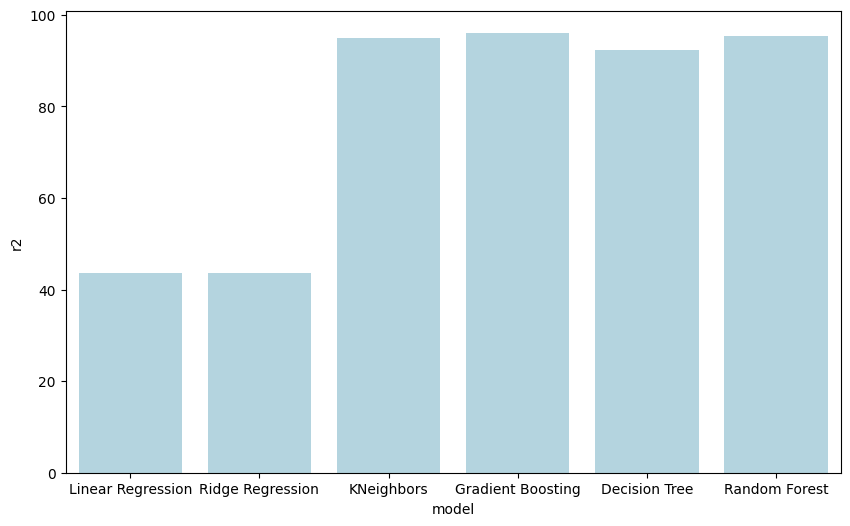

In [467]:
# r2 score comparison across models
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="model", y='r2', data=performance, color="lightblue");

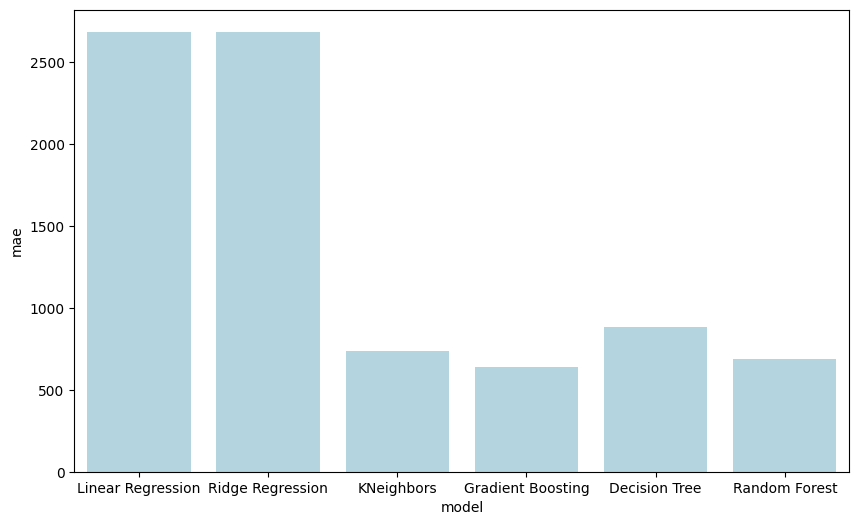

In [468]:
# mae score comparison across models
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="model", y='mae', data=performance, color="lightblue");

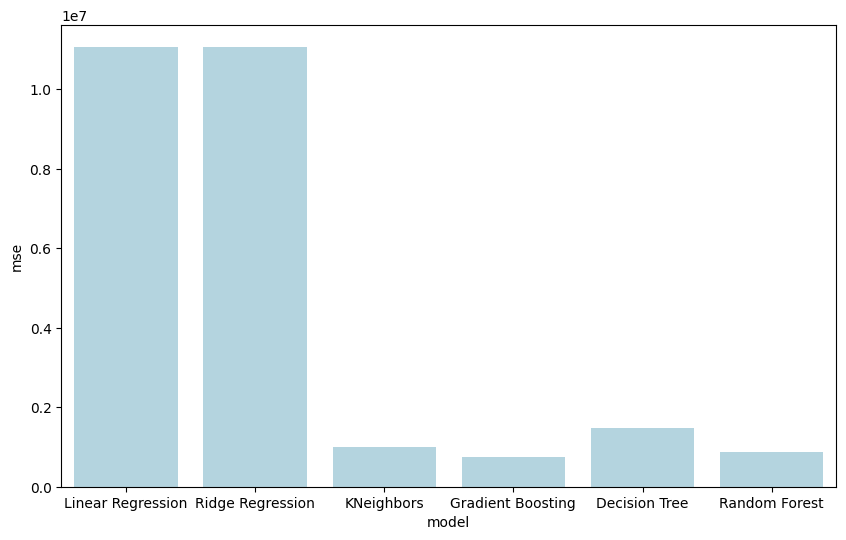

In [469]:
# mse score comparison across models
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="model", y='mse', data=performance, color="lightblue");

#**Neural Network**
Keras is a high-level neural network API. It runs on the top of TensorFlow and Theano and is very famous in the field of Deep Learning. It is one of the best libraries used for neural networks that follows a minimalist philosophy.

In [470]:
#For Neural Network

data = studio_anime.copy()

Y = pd.DataFrame(data['popularity']).squeeze()
X = pd.DataFrame(data.drop(['popularity'], axis=1))

#X = data[['popularity','rank','score']] #[:, :3] from 1st to 3rd column
#Y = data[['score']] #[:,-1] 'score' only
Y = Y.to_numpy().reshape(-1,1)

print(X.shape)
print(Y.shape)

(3952, 2)
(3952, 1)


In [471]:
#Scale the X and Y values to follow Standard Normal Distribution (SND). Therefore, it makes mean = 0 and scales the data to unit variance.
#StandardScaler comes into play when the characteristics of the input dataset differ greatly between their ranges,
#or simply when they are measured in different units of measure.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

scaler_X = preprocessing.StandardScaler().fit(X)
scaler_Y = preprocessing.StandardScaler().fit(Y)
X_scale = scaler_X.transform(X)
X_train, X_val_and_test, Y_train_unscaled, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.2)
X_val, X_test, Y_val_unscaled, Y_test_unscaled = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5) #
Y_train = scaler_Y.transform(Y_train_unscaled)
Y_val =  scaler_Y.transform(Y_val_unscaled)
Y_test =  scaler_Y.transform(Y_test_unscaled)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape) #1st is test data 2nd is train data 3rd is validation data

(3161, 2) (395, 2) (396, 2) (3161, 1) (395, 1) (396, 1)


In [472]:
# Simple Deep Neural Network (keras)
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [473]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               384       
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8705 (34.00 KB)
Trainable params: 8705 (34.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [474]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
hist = model.fit(X_train, Y_train,
                batch_size=128, epochs=32,
                validation_data=(X_val, Y_val)) # for 32 batch 4092/32 = 127.875, EPOCH is the iteration, every EPOCH will improve it, with every iteration, there is a sweet spot, over iteration will start increase loss.

Epoch 1/32
25/25 [==============================] - 1s 11ms/step - loss: 0.5724 - mse: 0.5724 - val_loss: 0.4335 - val_mse: 0.4335
Epoch 2/32
25/25 [==============================] - 0s 6ms/step - loss: 0.3951 - mse: 0.3951 - val_loss: 0.3326 - val_mse: 0.3326
Epoch 3/32
25/25 [==============================] - 0s 6ms/step - loss: 0.2999 - mse: 0.2999 - val_loss: 0.2432 - val_mse: 0.2432
Epoch 4/32
25/25 [==============================] - 0s 7ms/step - loss: 0.2255 - mse: 0.2255 - val_loss: 0.1932 - val_mse: 0.1932
Epoch 5/32
25/25 [==============================] - 0s 6ms/step - loss: 0.1871 - mse: 0.1871 - val_loss: 0.1560 - val_mse: 0.1560
Epoch 6/32
25/25 [==============================] - 0s 6ms/step - loss: 0.1685 - mse: 0.1685 - val_loss: 0.1416 - val_mse: 0.1416
Epoch 7/32
25/25 [==============================] - 0s 6ms/step - loss: 0.1499 - mse: 0.1499 - val_loss: 0.1292 - val_mse: 0.1292
Epoch 8/32
25/25 [==============================] - 0s 5ms/step - loss: 0.1382 - mse: 0.1

In [475]:
model.evaluate(X_test, Y_test)

13/13 [==============================] - 0s 6ms/step - loss: 0.0610 - mse: 0.0610


[0.060990553349256516, 0.060990553349256516]

In [476]:
Y_result_scaled = model.predict(X_test)
Y_result = scaler_Y.inverse_transform(Y_result_scaled)
print(Y_result)
print(Y_test_unscaled.reshape(Y_result.shape))

13/13 [==============================] - 0s 6ms/step
[[ 3434.0164  ]
 [11697.939   ]
 [ 2318.7095  ]
 [ 9119.127   ]
 [ 7099.724   ]
 [  545.2985  ]
 [10811.395   ]
 [ 5194.445   ]
 [ 3104.7117  ]
 [  457.92252 ]
 [ 6727.909   ]
 [10233.734   ]
 [13090.779   ]
 [  705.7619  ]
 [ 2948.9795  ]
 [ 5204.616   ]
 [13057.515   ]
 [13223.928   ]
 [10905.661   ]
 [13512.495   ]
 [11004.566   ]
 [ 5886.375   ]
 [  691.8298  ]
 [ 3613.8237  ]
 [ 2210.1655  ]
 [ 9644.564   ]
 [10287.311   ]
 [11840.802   ]
 [ 8320.11    ]
 [ 1417.778   ]
 [  267.51724 ]
 [ 3278.6753  ]
 [10425.641   ]
 [10228.502   ]
 [11437.346   ]
 [ 4133.2563  ]
 [13835.766   ]
 [ 9718.644   ]
 [ 9878.648   ]
 [ 1497.4191  ]
 [ 6197.63    ]
 [ 4533.6113  ]
 [ 1123.4908  ]
 [10670.471   ]
 [10225.082   ]
 [ 1008.08514 ]
 [  525.07684 ]
 [ 4957.9795  ]
 [ 2009.4901  ]
 [ 9886.56    ]
 [ 3535.8726  ]
 [ 2311.6147  ]
 [ 2824.3796  ]
 [ 4143.001   ]
 [ 9532.542   ]
 [ 9522.443   ]
 [ 3195.9465  ]
 [ 9541.429   ]
 [ 1488.3644  ]
 [ 

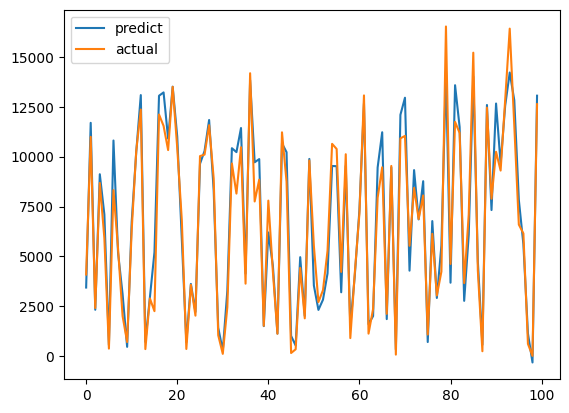

In [477]:
axis_x = [i for i in range(100)]

plt.plot(axis_x, Y_result[:100], label='predict')
plt.plot(axis_x, Y_test_unscaled[:100], label='actual')
plt.legend()
plt.show()

The prediction is relatively close to the actual, which is similar results to the Gradient Boosted Regression model.

This means despite medium corr between popularity to score and statistics_plan_watch, when regression model is applied, they show that popularity can be guaged by score and statistics_plan_watch. Eg. if score and statistics_plan_watch is at a certain value, popularity of an action anime can be predicted.

#**Rolling Average**
A rolling average continuously updates the average of a data set to include all the data in the set until that point. We've set it to 1 year intervals (12 months).

Text(0.5, 1.0, 'Popularity for Genre (Action) Data')

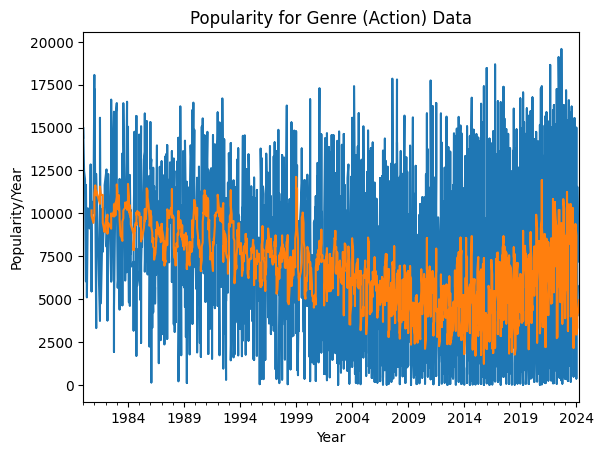

In [478]:
ma3 = studio_anime['popularity'].rolling(window=12).mean()

# Show plot
plt.show()

ma3 = studio_anime['popularity'].rolling(window=12).mean()
# Plot the original time series
ax = studio_anime['popularity'].plot()

# Plot the moving average over the original time series
ma3.plot()

# Specify the x- and y- axis labels and titles in your plot
ax.set_xlabel('Year')
ax.set_ylabel('Popularity/Year')
ax.set_title('Popularity for Genre (Action) Data')

#**Exponential Smoothing (ETS Models)**
Statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models. Statsmodels library provides a handy function call to separate out these elements, giving a direct view of how different elements contributing to the overall behaviors.

Simple Exponential Smoothing : Basic smoothing with only a level component [SimpleExpSmoothing model]
Double Exponential Smoothing : Smoothing with a trend component [Holt model]
Triple Exponential Smoothing : Smoothing with trend and seasonal components [ExponentialSmoothing model]

In [479]:
!pip install statsmodels

In [480]:
studio_anime.drop(['score', 'statistics_plan_to_watch'], axis=1, inplace=True)

In [492]:
train1 = studio_anime[:int(studio_anime.shape[0]*0.8)]
test1  = studio_anime[int(studio_anime.shape[0]*0.8):]

print(type(train1.values))
print(train1.values[:5])

<class 'numpy.ndarray'>
[[14409]
 [15015]
 [12461]
 [11987]
 [ 6034]]


In [494]:
# Convert PeriodIndex to DateTimeIndex if needed
if isinstance(train1.index, pd.PeriodIndex):
    train1.index = train1.index.to_timestamp()

if isinstance(test1.index, pd.PeriodIndex):
    test1.index = test1.index.to_timestamp()

In [495]:
# Ensure data is float type
train1 = train1.astype(float)
test1 = test1.astype(float)

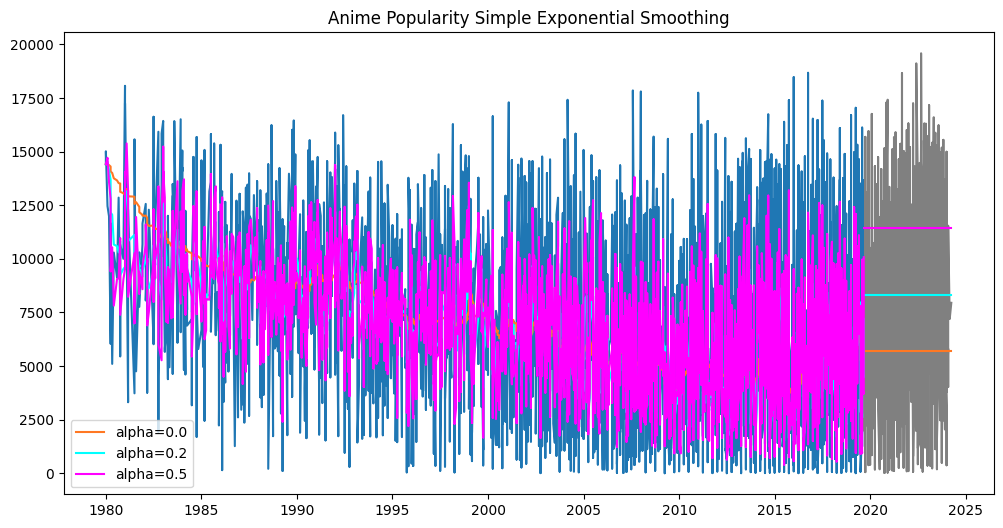

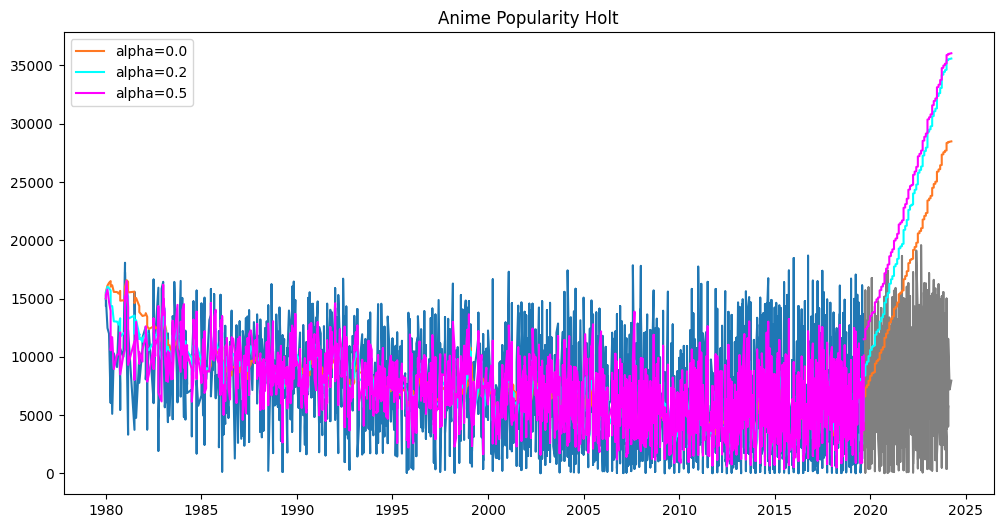

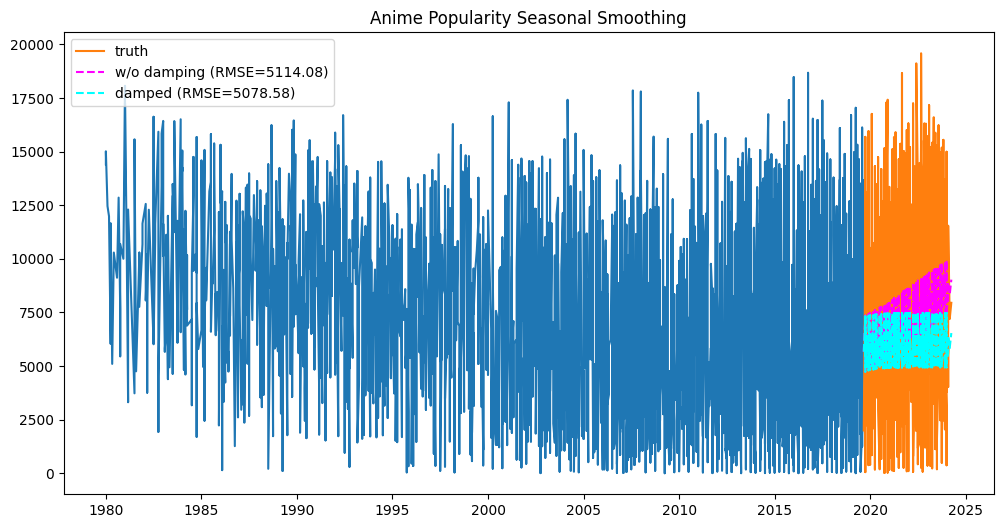

In [504]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 3. Time series forecast using ETS model [CODE]

test_duration1 = len(test1)

#____________________________________________________________________Simple Exponential

model0 = SimpleExpSmoothing(train1)

fit1_0 = model0.fit()
pred1_0 = fit1_0.forecast(test_duration1)
fit2_0 = model0.fit(smoothing_level=.2)
pred2_0 = fit2_0.forecast(test_duration1)
fit3_0 = model0.fit(smoothing_level=.5)
pred3_0 = fit3_0.forecast(test_duration1)

fig, ax0 = plt.subplots(figsize=(12, 6))
ax0.plot(train1.index[:], train1.values[:])
ax0.plot(test1.index, test1.values, color="gray")
for p, f, c in zip((pred1_0, pred2_0, pred3_0),(fit1_0, fit2_0, fit3_0),('#ff7823','cyan','magenta')):
    ax0.plot(train1.index[:], f.fittedvalues[:], color=c)
    ax0.plot(test1.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Anime Popularity Simple Exponential Smoothing")
plt.legend();

#____________________________________________________________________ Double Exponential

model3 = Holt(train1)

fit1_3 = model3.fit()
pred1_3 = fit1_3.forecast(test_duration1)
fit2_3 = model3.fit(smoothing_level=.2)
pred2_3 = fit2_3.forecast(test_duration1)
fit3_3 = model3.fit(smoothing_level=.5)
pred3_3 = fit3_3.forecast(test_duration1)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(train1.index[:], train1.values[:])
ax1.plot(test1.index, test1.values, color="gray")
for p, f, c in zip((pred1_3, pred2_3, pred3_3),(fit1_3, fit2_3, fit3_3),('#ff7823','cyan','magenta')):
    ax1.plot(train1.index[:], f.fittedvalues[:], color=c)
    ax1.plot(test1.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Anime Popularity Holt")
plt.legend();

#_____________________________________________________________________ Triple Exponential

model1 = ExponentialSmoothing(train1, trend="add", seasonal="add", seasonal_periods=12) #inferred frequency will be 2H based on 2H data provided, (2*12= 24H = 1Day)
model2 = ExponentialSmoothing(train1, trend="add", seasonal="add", seasonal_periods=12, damped_trend=True)

fit1_1 = model1.fit()
pred1_1 = fit1_1.forecast(test_duration1)
fit2_1 = model2.fit()
pred2_1 = fit2_1.forecast(test_duration1)

sse1_1 = np.sqrt(np.mean(np.square(test1.values - pred1_1.values)))
sse2_1 = np.sqrt(np.mean(np.square(test1.values - pred2_1.values)))

fig, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(train1.index, train1.values);
ax2.plot(test1.index, test1.values, label='truth');

ax2.plot(test1.index, pred1_1, linestyle='--', color='magenta', label="w/o damping (RMSE={:0.2f})".format(sse1_1));
ax2.plot(test1.index, pred2_1, linestyle='--', color='cyan', label="damped (RMSE={:0.2f})".format(sse2_1));

ax2.legend();
ax2.set_title("Anime Popularity Seasonal Smoothing");

#**ARIMA**
ARIMA stands for AutoRegressive Integrated Moving Average and represents a cornerstone in time series forecasting. It is a statistical method that has gained immense popularity due to its efficacy in handling various standard temporal structures present in time series data.

In [505]:
# To install specific version of statsmodels for ETS modeling
! pip install --upgrade statsmodels==0.14.2 # possible choices= 0.10.2, 0.12.1, 0.13.2

In [506]:
pip install pmdarima

In [516]:
train1.head()

,popularity
year_month,
1980-01-01,14409.0
1980-01-01,15015.0
1980-02-01,12461.0
1980-03-01,11987.0
1980-04-01,6034.0


In [517]:
train1.head()

,popularity
year_month,
1980-01-01,14409.0
1980-01-01,15015.0
1980-02-01,12461.0
1980-03-01,11987.0
1980-04-01,6034.0


ADF (Augmented Dickey Fuller) Test
Alternate Hypothesis: The series has no unit root. If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

In [518]:
from statsmodels.tsa.stattools import adfuller

significance_level = 0.05

# Now run the ADF test
adf_test = adfuller(train1, regression='c', autolag='BIC')

p_value = adf_test[1]

print("ADF p-value: {:0.5f}".format(p_value))
print("Stationary by ADF: {}".format("Yes" if p_value < significance_level else "No"), '\n')

ADF p-value: 0.00000
Stationary by ADF: Yes 



In [520]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train1.dropna(),
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd', alternatively d can be set to fixed value below.
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=0,              # Set d according to the nature of data, 0 if stationary and 1 if need 1st differencing before stationarity
                      seasonal=False,   # No Seasonality, use ARIMA only, not SARIMAX
                      trace=True,
                      error_action='ignore',   # don't want to know if an order does not work
                      suppress_warnings=True,  # don't want convergence warnings
                      stepwise=True,)    # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65237.688, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=62873.820, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=64222.393, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=62246.572, Time=0.42 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=62020.191, Time=0.67 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=61903.131, Time=0.76 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=61793.664, Time=0.99 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=61721.559, Time=1.17 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=61657.511, Time=2.79 sec
 ARIMA(8,0,0)(0,0,0)[0]             : AIC=61639.215, Time=2.23 sec
 ARIMA(9,0,0)(0,0,0)[0]             : AIC=inf, Time=2.75 sec
 ARIMA(8,0,1)(0,0,0)[0]             : AIC=inf, Time=7.98 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=inf, Time=9.16 sec
 ARIMA(9,0,1)(0,0,0)[0]             : AIC=inf, Time=11.87 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept   : AIC=

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

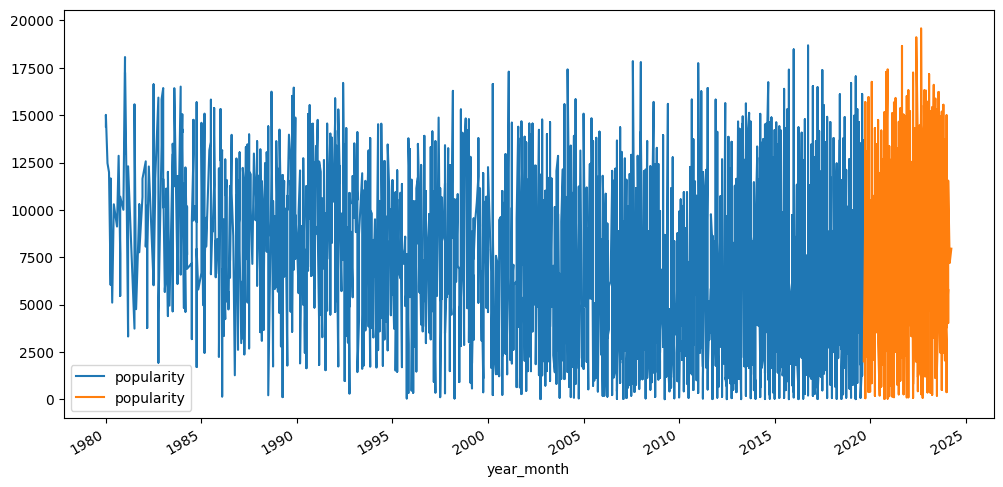

In [529]:
# Implement the ARIMA Model: copy p,d,q from the best performing model obtained from Auto-ARIMA command above.
# Do forecast over test data
from statsmodels.graphics.tsaplots import plot_predict

p, d, q = 8, 0, 0 # Fit in the values of p, d and q generated by Auto ARIMA

model = ARIMA(train1.dropna(), order =(p, d, q))
model_fit = model.fit()

fig, ax = plt.subplots(figsize=(12, 6))

train1.index = pd.to_datetime(train1.index, format="%Y-%m")
test1.index = pd.to_datetime(test1.index, format="%Y-%m")

train1.plot(ax=ax);
test1.plot(ax=ax, label='Action'+'test')
ax.vlines(test1.index[0], 5, 6.5, linestyle='--', color='r', label='Start of forecast');

# Predict/Forecast and Plot using the model
# Ensure that 'start' and 'end' are valid dates in your data's index
start_forecast = str(test1.index[0].date())
end_forecast = str(test1.index[-1].date())

# Predict/Forecast and Plot using the model
plot_predict(model_fit, start=start_forecast, end=end_forecast, dynamic=True, plot_insample=False, ax=ax);

# Calculate and display RMSE in Title
test_duration = len(test1)
pred = model_fit.forecast(test_duration)

sse = np.sqrt(np.mean(np.square(test1.values.reshape(1,-1)[0]- pred[0])))
ax.set_title("ARIMA Forecast with Auto_ARIMA ( RMSE={:0.3f} )".format(sse));


Our data for action, anime popularity over time is a poor fit for ML tecniques such as exponential smoothing and ARIMA, likely the variance and gaps in data eg. periods where there is 0 action anime, is the cause.

#**Conclusion**

We have found that despite moderate corr; score and statistics_plan_watch can be used to accurately predict popularity, however it is not data where they are directly proportionate to one another, it is more of matching values to determine popularity for a specific anime. As the resulting graphs are non linear.

For Exponential Smoothing and ARIMA, based purely on action popularity over time, the results show that, the data set lacks seasonality or trend, hence the ADF test indicates stationary and a stationary time series has statistical properties or moments (e.g., mean and variance) that do not vary in time, this makes it unsuitable.

For our Anime Data, most of our numeric data is varied and would not be non stationary, as well as show any indication they are seasonal or have a trend, as all we have tested so far is the final score of anime of a specific genre. This is because Anime itself is subjective like art, it has non-deterministic qualities which make it hard to predict or forecast, in essence Anime rating is largely unpredictable in terms of how people view it.

However, if we were to measure the per episode score of a long running anime series like, naruto or bleach, it may be possible to predict score better or identify seasonality as anime has peaks and lulls in terms of story arc.